In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
asse = pd.read_csv('assessments.csv')
cour = pd.read_csv('courses.csv')
stuI = pd.read_csv('studentInfo.csv')
stuR = pd.read_csv('studentRegistration.csv')
stuA = pd.read_csv('studentAssessment.csv')
stuV = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

# QUESTIONS ASKED

1. Can the gender, age and interaction in the vle help to predict assessment scores for each module?
2. Can the given studnet information and interaction be used to predict the results of assessments?

In [3]:
asse.drop(['code_presentation','assessment_type','date','weight'], axis = 1, inplace = True)

We only need code_module in order to match with student assessment and student info

In [4]:
comb_asse = pd.merge(stuA, asse,on='id_assessment')
comb_asse.drop(['is_banked','date_submitted'],axis = 1,inplace=True)
comb_asse.dtypes

id_assessment      int64
id_student         int64
score            float64
code_module       object
dtype: object

Match each assessment data to the modules they belong to

In [5]:
comb_asse.shape

(173912, 4)

In [6]:
grouped = comb_asse.groupby(['id_student','code_module']).mean()
grouped.sort_values('id_student')

grouped.drop(['id_assessment'],axis=1,inplace = True)
grouped.head()

,,score
id_student,code_module,
6516,AAA,61.800000
8462,DDD,87.000000
11391,AAA,82.000000
23629,BBB,82.500000
23698,CCC,74.444444


Group by student and by subgroup so we can be able to predict module

In [7]:
stuI.shape

(32593, 12)

Text(0, 0.5, 'Number of students')

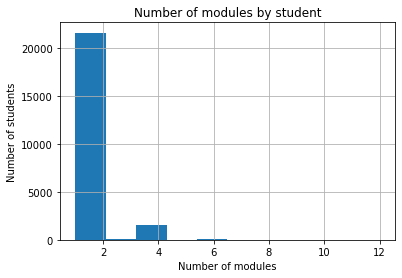

In [8]:
student_all_info = pd.merge(stuI,grouped,on='id_student')
fig1 = student_all_info.groupby(['id_student']).code_module.count().sort_values().hist()
fig1.set_title('Number of modules by student')
fig1.set_xlabel('Number of modules')
fig1.set_ylabel('Number of students')

Acording to the results above, most of students enroled in one module.

In [9]:
vle_grouped = stuV.groupby(['id_student','code_module']).sum()
vle_grouped.drop(['id_site','date'],axis=1,inplace=True)
vle_grouped.head()

,,sum_click
id_student,code_module,
6516,AAA,2791
8462,DDD,656
11391,AAA,934
23629,BBB,161
23698,CCC,910


In [10]:
df = pd.merge(student_all_info,vle_grouped,on = ['id_student','code_module'],how='left')

In [11]:
df.dropna(inplace=True)

In [12]:
df.to_csv('joinedData.csv',index=False)

We have removed null values, and joined and saved our new csv file. So we now have a dataframe with student info, average assessment score for that module and average number of clicks for that module.

In [13]:
df.code_module = pd.Categorical(df.code_module)
df.code_presentation = pd.Categorical(df.code_presentation)
df.gender = pd.Categorical(df.gender)
df.region = pd.Categorical(df.region)
df.highest_education = pd.Categorical(df.highest_education)
df.imd_band = pd.Categorical(df.imd_band)
df.age_band = pd.Categorical(df.age_band)
df.disability = pd.Categorical(df.disability)
df.final_result = pd.Categorical(df.final_result)

Index(['A Level or Equivalent', 'HE Qualification', 'Lower Than A Level',
       'No Formal quals', 'Post Graduate Qualification'],
      dtype='object')

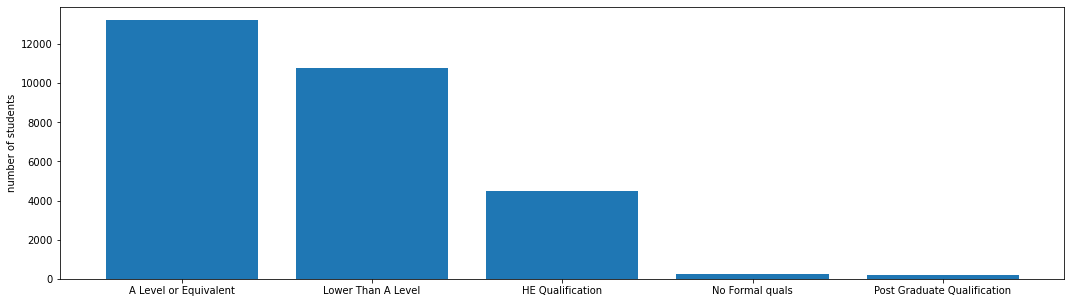

In [14]:
highest_ed = df.highest_education.value_counts()
f, ax = plt.subplots(figsize=(18,5))
ax.bar(highest_ed.index,highest_ed)
ax.set_ylabel('number of students')
df.highest_education.cat.categories

Nomal Formal equal and Post Grad have lower number of students, so we cannot generalize with these values

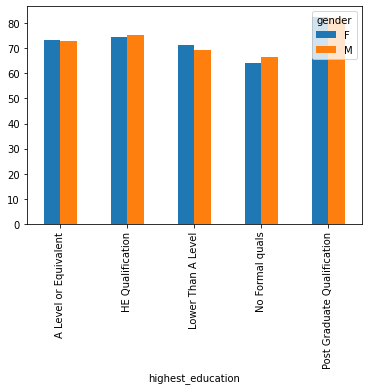

In [15]:
for_bar = df.pivot_table(index = 'highest_education', columns='gender', values = 'score')
for_bar.plot(kind='bar')

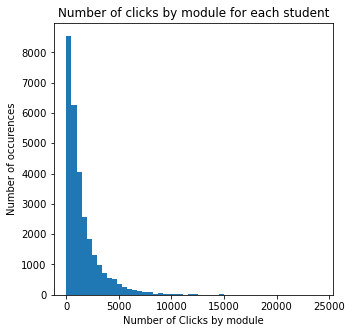

In [16]:
interaction_by_module = df.sum_click
fig2, ax2 = plt.subplots(figsize=(5,5));
ax2.hist(interaction_by_module,bins=50);
ax2.set_xlabel('Number of Clicks by module');
ax2.set_title('Number of clicks by module for each student');
ax2.set_ylabel('Number of occurences');

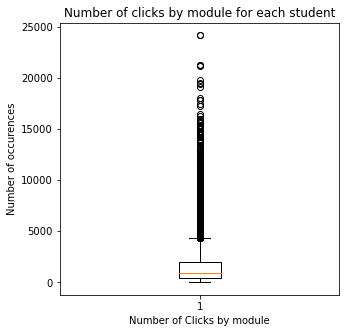

In [17]:
interaction_by_module = df.sum_click
fig2, ax2 = plt.subplots(figsize=(5,5));
ax2.boxplot(interaction_by_module);
ax2.set_xlabel('Number of Clicks by module');
ax2.set_title('Number of clicks by module for each student');
ax2.set_ylabel('Number of occurences');

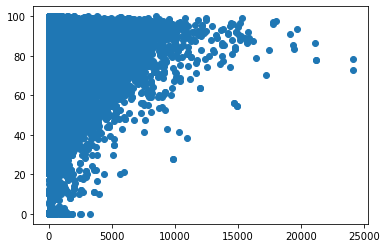

In [18]:
plt.scatter((df.sum_click),(df.score))

Most of students perform between 0 and 500 clicks in each module, and also there is a positive linear relationship between average assessment score and clicks in each module. There are obvious outliers in the data.

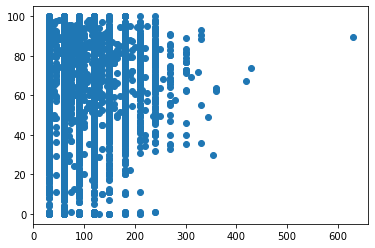

In [19]:
plt.scatter((df.studied_credits),(df.score))

In [20]:
bins = [0,50,100,150,200,250,300,350,400,450,500,550,600]
df['studied_credits'] = pd.cut(df['studied_credits'], bins=bins)

In [21]:
df2 = df.groupby(['gender','code_module']).score.mean()

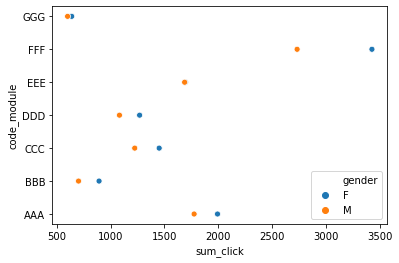

In [22]:
df3 = df.groupby(['gender','code_module']).sum_click.mean()
codes =  df2.index.get_level_values(1)
codes
sns.scatterplot(df3,df3.index.get_level_values(1), hue = df2.index.get_level_values(0), legend='full');

The results show that female students seem to engage more with vle.

# Does the higher engagement of females contribute to higher scores?
## What about the number of clicks in terms of influencing the results?

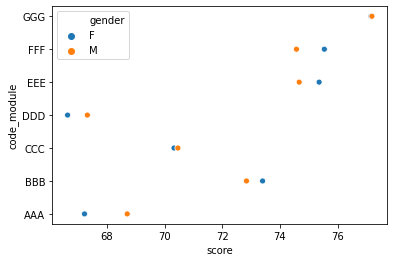

In [23]:
import seaborn as sns
codes =  df2.index.get_level_values(1)
codes
sns.scatterplot(df2,df2.index.get_level_values(1), hue = df2.index.get_level_values(0), legend='full');

The performance based on the gender is not that big in each module.

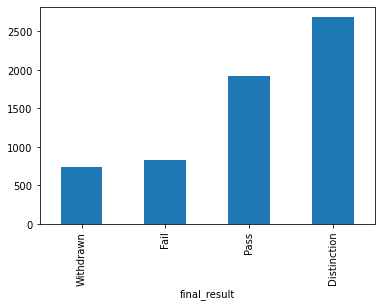

In [24]:
df.groupby('final_result').sum_click.mean().sort_values().plot(kind='bar',)

Final score and vle engagement have some patterns.

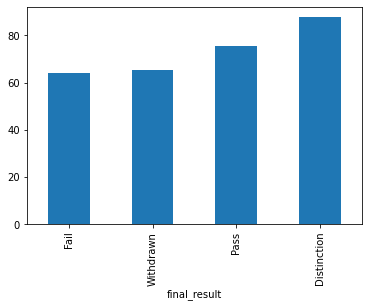

In [25]:
df.groupby('final_result').score.mean().sort_values().plot(kind='bar',)

The output above also prove the connection beteen final results and number of clicks

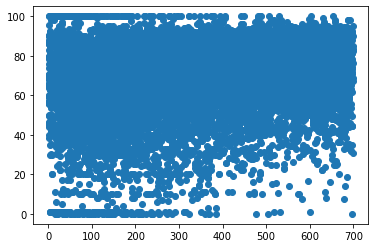

In [26]:
plt.scatter((df.sum_click[df.sum_click < 700]),(df.score[df.sum_click < 700]))

We have seen that number there is a relationship between number of clicks and final result, and particularly that it might be possible at the lower end of engagement to predict withdrawal or failure from VLE engagement. However our independent variables by themselves don't seem to be predictive of mean assessment score.

In [27]:
df.describe()

,id_student,num_of_prev_attempts,score,sum_click
count,2.893900e+04,28939.000000,28939.000000,28939.000000
mean,7.061386e+05,0.152631,72.275828,1529.447044
std,5.481240e+05,0.460283,16.893861,1770.249637
min,6.516000e+03,0.000000,0.000000,1.000000
25%,5.087540e+05,0.000000,64.000000,405.000000
50%,5.895690e+05,0.000000,75.750000,931.000000
75%,6.365795e+05,0.000000,84.444444,1992.000000
max,2.698588e+06,6.000000,100.000000,24139.000000


base on the output, we van see that there is a large variation sum_of_prev_attemps is positively skewd

In [28]:
corr = df.corr()
corr

,id_student,num_of_prev_attempts,score,sum_click
id_student,1.000000,0.018289,0.024087,0.042417
num_of_prev_attempts,0.018289,1.000000,-0.075522,-0.033830
score,0.024087,-0.075522,1.000000,0.261564
sum_click,0.042417,-0.033830,0.261564,1.000000


There is no significant multicollinearity between independent variables

Next, let's normalise the continuous variables - num_of_prev_attempts, studied_credits,score,date, sum_clicks, plus the target variable score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001390B0174C0>,
      dtype=object)

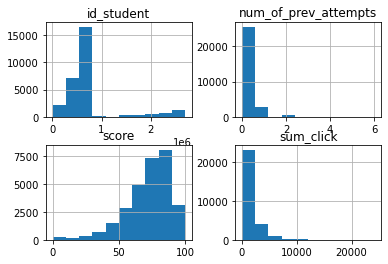

In [29]:
df.hist()

In [30]:
print("Kurtosis",df.kurtosis(axis=0))
print("Skew",df.skew(axis=0))
print("Target Kurtosis",df_target.kurtosis(axis=0))
print("Target Skew",df_target.skew(axis=0))

Kurtosis id_student               5.193744
num_of_prev_attempts    20.086814
score                    2.229635
sum_click               14.664061
dtype: float64
Skew id_student              2.450011
num_of_prev_attempts    3.872397
score                  -1.263480
sum_click               2.935201
dtype: float64


NameError: name 'df_target' is not defined

All variables have positive skewness and kurtosis nowhere near zero. However we can't log transform with the data we have, as there are lots of invalid values including 0s.

# QUESTION 3

In [31]:
import os
import logging
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt

In [32]:
!pip install fastscore

  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8213 sha256=2719c3c678728934bfa9dba61936e4183acc2d69c48cb27c87c8bc81cf281514
  Stored in directory: c:\users\student\appdata\local\pip\cache\wheels\a1\09\42\0b963b1d5423ddc87cb4ba9f475e09838d3813300b52a866ea
Successfully built ordered-set


In [33]:
!pip install fastai

  Using cached fastai-2.1.5-py3-none-any.whl (188 kB)


ERROR: Could not find a version that satisfies the requirement torch>=1.7.0 (from fastai) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
ERROR: No matching distribution found for torch>=1.7.0 (from fastai)
